In [1]:
%matplotlib inline

In [2]:
import numpy as np
import random
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras import backend as K
from keras.utils.vis_utils import plot_model, model_to_dot
from IPython.display import SVG
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
num_classes = 10
epochs = 20


In [5]:
def euclidean_distance(vects):
    x,y = vects
    sum_square = K.sum(K.square(x-y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [6]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [7]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1-y_true) * margin_square)


In [8]:
def create_pairs(x, digit_indices):
    
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]] # positive sample
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i] # negative sample
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


In [9]:
def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)

In [10]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


In [11]:
def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [12]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]

In [13]:
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

In [14]:
print("Shape of training pairs", tr_pairs.shape)
print("Shape of training labels", tr_y.shape)

Shape of training pairs (108400, 2, 28, 28)
Shape of training labels (108400,)


In [15]:
# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape, name='input_a')
input_b = Input(shape=input_shape, name='input_b')

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)


In [16]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_a (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
input_b (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128)          133504      input_a[0][0]                    
                                                                 input_b[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           model_1[1][0]                    
          

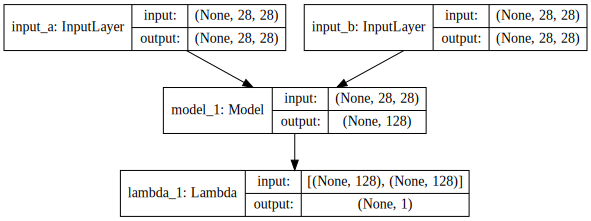

In [17]:
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

In [18]:
# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

Train on 108400 samples, validate on 17820 samples
Epoch 1/20
108400/108400 [==============================] - 21s 198us/step - loss: 0.0947 - accuracy: 0.8890 - val_loss: 0.0434 - val_accuracy: 0.9586
Epoch 2/20
108400/108400 [==============================] - 16s 149us/step - loss: 0.0387 - accuracy: 0.9633 - val_loss: 0.0302 - val_accuracy: 0.9680
Epoch 3/20
108400/108400 [==============================] - 17s 154us/step - loss: 0.0267 - accuracy: 0.9733 - val_loss: 0.0248 - val_accuracy: 0.9737
Epoch 4/20
108400/108400 [==============================] - 16s 146us/step - loss: 0.0211 - accuracy: 0.9788 - val_loss: 0.0242 - val_accuracy: 0.9728
Epoch 5/20
108400/108400 [==============================] - 16s 146us/step - loss: 0.0179 - accuracy: 0.9816 - val_loss: 0.0236 - val_accuracy: 0.9726
Epoch 6/20
108400/108400 [==============================] - 18s 169us/step - loss: 0.0157 - accuracy: 0.9841 - val_loss: 0.0242 - val_accuracy: 0.9722
Epoch 7/20
108400/108400 [=================

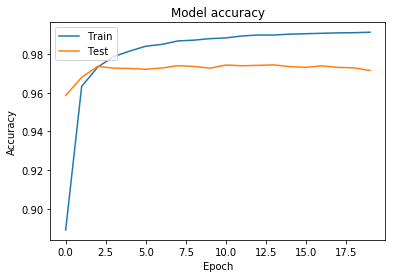

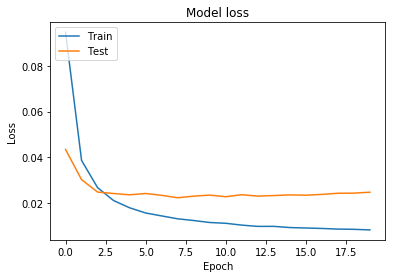

In [20]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [21]:
# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)


In [22]:
print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))


* Accuracy on training set: 99.60%
* Accuracy on test set: 97.15%


In [25]:
model.evaluate([te_pairs[:, 0], te_pairs[:, 1]], te_y)

17820/17820 [==============================] - 1s 66us/step


[0.0247481479397562, 0.9715488215488215]